In [11]:
import pandas as pd
import numpy as np
import requests
import os
import json
from datetime import datetime

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go

import dash
import dash_core_components as dcc
import dash_html_components as html
pd.set_option('display.max_rows',500) 

In [12]:
#Visual Setup for Seaborn

sns.set(style="darkgrid")
mpl.rcParams['figure.figsize'] = (18, 11)


# Business Understanding


![CRISP_DM](crisp_dm2.png)

We would like to track the COVID-19 Virus spread across the countries and with personal info.

The general information is not so relevant for me.
I would like to have a deep dive in local development of the spread.

# Explorative Data Analysis
* Focus on visual representation of data

In [13]:
df_plot = pd.read_csv('C:/Users/patka/enterprise_data_science-covid-19/data/processed/COVID_small_flat_table.csv', sep=';')

df_plot.head()

,Unnamed: 0,date,Italy,US,Spain,Germany,"Korea, South"
0,0,1/22/20,0,1,0,0,1
1,1,1/23/20,0,1,0,0,1
2,2,1/24/20,0,2,0,0,2
3,3,1/25/20,0,2,0,0,2
4,4,1/26/20,0,5,0,0,3


# Matplotlib Example : Date vs Infected People (Log Scale) 

<Figure size 1296x792 with 0 Axes>

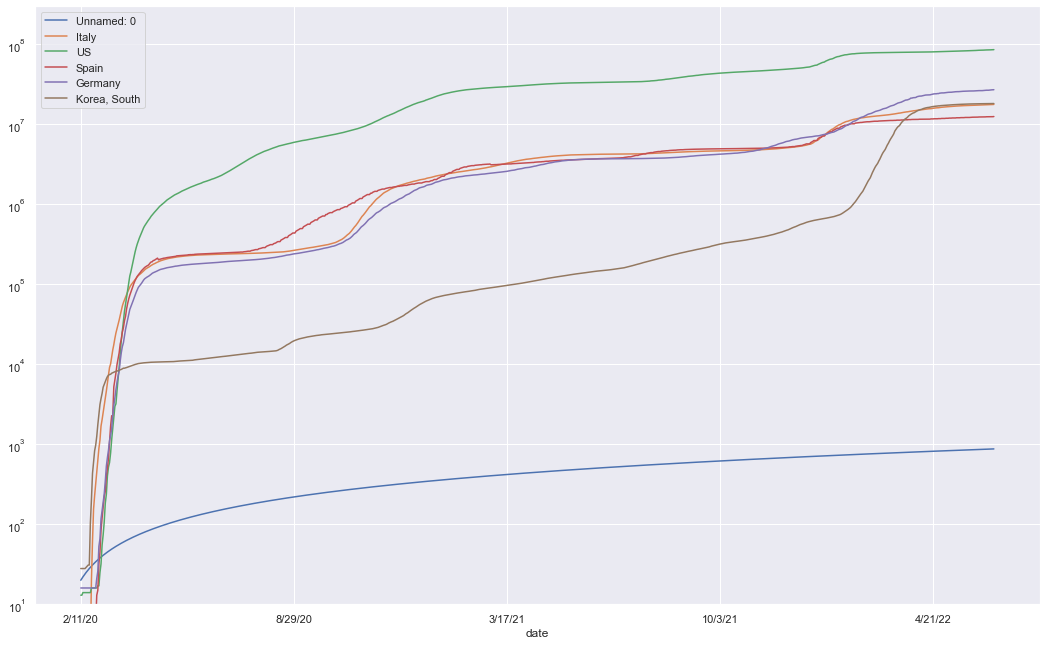

In [14]:
plt.figure();
ax = df_plot.iloc[20:,:].set_index('date').plot()
plt.ylim(10,300000000)
ax.set_yscale('log')

In [15]:
wp_country = pd.read_csv(r'C:\Users\patka\enterprise_data_science-covid-19\data\COVID-19-master\data_tables\world_pop_by_country.csv')

wp_country.head()

,Country Name,Country Code,2018
0,Aruba,ABW,105845.0
1,Afghanistan,AFG,37172386.0
2,Angola,AGO,30809762.0
3,Albania,ALB,2866376.0
4,Andorra,AND,77006.0


In [16]:
country_list=['Italy', 'US', 'Spain', 'Germany', 'Korea, South']
population=[]
for each in country_list:
    population = wp_country.loc[wp_country["Country Name"] == each , "2018"]
    
population

124    51635256.0
Name: 2018, dtype: float64

In [17]:
for each in country_list:
    var = np.array(wp_country.loc[wp_country["Country Name"] == each ,"2018"]).astype(int)
    df_plot[each] = df_plot[each]/var[0]
df_plot

,Unnamed: 0,date,Italy,US,Spain,Germany,"Korea, South"
0,0,1/22/20,0.000000,3.056539e-09,0.000000,0.000000,1.936661e-08
1,1,1/23/20,0.000000,3.056539e-09,0.000000,0.000000,1.936661e-08
2,2,1/24/20,0.000000,6.113078e-09,0.000000,0.000000,3.873323e-08
3,3,1/25/20,0.000000,6.113078e-09,0.000000,0.000000,3.873323e-08
4,4,1/26/20,0.000000,1.528269e-08,0.000000,0.000000,5.809984e-08
...,...,...,...,...,...,...,...
873,873,6/13/22,0.292300,2.618428e-01,0.267080,0.324560,3.532287e-01
874,874,6/14/22,0.292959,2.621242e-01,0.267854,0.325674,3.534112e-01
875,875,6/15/22,0.293502,2.626829e-01,0.267854,0.326748,3.535657e-01
876,876,6/16/22,0.294115,2.630388e-01,0.267854,0.327088,3.537049e-01


# Plot.ly

In [18]:
fig = go.Figure()
# Defines how to plot individual trace
country_list=['Italy', 'US', 'Spain', 'Germany', 'Korea, South']
for each in country_list:
    fig.add_trace(go.Scatter(x=df_plot.date,
                        y=df_plot[each],
                        mode = 'markers + lines',
                        marker_size = 2.5,
                        opacity = 0.8,
                        line_width = 1.5,
                        name = each))

# Defines overall layout
fig.update_layout(
    width=1000,
    height=800,
    xaxis_title="Time",
    yaxis_title="Confirmed Cases(Data from JHU, log scale)"
)
fig.update_yaxes(type="linear") 
fig.update_layout(xaxis_rangeslider_visible = True)
#fig.show(renderer='jpg')

# Creating a Dashboard

In [19]:
app = dash.Dash()
app.layout = html.Div([
    
    html.Label('Multi-Select Country'),
    dcc.Dropdown(
        id = 'country_drop_down',
        options = [
            {'label': 'Italy', 'value': 'Italy'},
            {'label': 'US', 'value': 'US'},
            {'label': 'Spain', 'value': 'Spain'},
            {'label': 'Germany', 'value': 'Germany'},
            {'label': 'Korea, South', 'value': 'Korea, South'}
        ],
        value = ['US', 'Germany'],
        multi = True
    ),
    
    dcc.Graph(figure=fig, id = 'main_window_slope')
])


In [20]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])

def update_figure(country_list):
    
    traces = []
    for each in country_list:
        traces.append(dict(x=df_plot.date,
                           y= df_plot[each],
                           mode = 'markers+lines',
                           opacity= 0.9,
                           line_width =2,
                           marker_size = 4,
                           name = each
                          )
                     )
    return {
        'data' : traces,
        'layout': dict(
            width = 1600,
            height = 1200,
            xaxis_title = "Time",
            yaxis_title = "confirmed infected people (Joh hopkins data set, log-scale)",
            xaxis = {'tickangle': -45,
                    'nticks': 20,
                    'tickfont': dict(size = 14, color = "#7f7f7f"),
                    },
            yaxis = {'type': "linear",
                    'range': '[1.1,5.5]'
                    }
        )
    }

# Using online server for dashboard visualization

In [ ]:
#Turn off reloader if inside jupyter

app.run_server(debug = True, use_reloader = False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
